#### import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [71]:
RANDOM_SEED: int = 42

tf.random.set_seed(RANDOM_SEED)

## --- Run this code once ---

You only need to run the cell below once, it will convert the images into tensors and save them in a new directory. It will be much faster to load and use the tensors instead whenever you restart your kernel.

The sample solutions assume an organization like this:
```
project_root/
├── notebooks/
|   └── this_notebook.ipynb
└── data
    ├── raw/
    |   ├── A/
    |   ├── B/
    |   └── C/
    └── processed/      <-- created by the code below
        ├── train/
        └── val/
```

In [72]:
# Loading in dataset
train_ds, val_ds = image_dataset_from_directory(
    directory='../data/raw',    #path to folder with images
    labels='inferred',          #infer labels from directories
    label_mode='int',           #this means we still use sparse_categorical_crossentropy for loss
    image_size=(256, 256),      #dimensions of image after loading
    shuffle=True,               #shuffles data before split
    seed=42,                    #fix random shuffling (independently from global random seed)
    validation_split=0.1,       #size of validation set
    subset='both',              #return both validation and training sets
    pad_to_aspect_ratio=True,   #pad if images not perfectly square to avoid warping the aspect ratio
    batch_size=None             #we'll batch the tensors instead in the code below
)

# Saving tensor dataset (faster to load than raw images)
os.makedirs('../data/processed', exist_ok=True)
train_ds.save('../data/processed/train')
val_ds.save('../data/processed/val')

Found 690 files belonging to 3 classes.
Using 621 files for training.
Using 69 files for validation.


Caching the dataset after loading stores it in RAM which can make things significantly faster. But, we have to be careful that it won't take up too much RAM. This code will check the total size of the datasets, if it is larger than ~70% of your computer's RAM it might not be worth it to cache.

In [73]:
# Calculating size of datasets to determine if caching is possible
num_imgs = sum(tf.data.experimental.cardinality(ds).numpy() for ds in (train_ds, val_ds))

img_spec = train_ds.element_spec[0]

hieght, width, channels = img_spec.shape
dtype_size = img_spec.dtype.size

total_bytes = num_imgs * hieght * width * channels * dtype_size
print(f'Total Dataset Size: {total_bytes / (1024**3)}GB')

Total Dataset Size: 0.50537109375GB


In our case, this dataset, now that it is being stored efficiently as tensors, takes up only a small portion of the computer's total RAM meaning caching is a good idea. We do this while loading in the dataset.

## --- Run this each time ---

We can also set up prefetching, this will grab the next tensor in the dataset while the model is still training on the current one so that it is ready-to-go as soon as the current batch finishes. In order to do this, we'll need to batch the data as we are loading it instead of at the `.fit` stage. We should also bring in `AUTOTUNE` to handle the prefetching in an optimized way. 

In [74]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE: int = 32

In [75]:
# Load tensor dataset
train_ds = Dataset.load('../data/processed/train')
val_ds = Dataset.load('../data/processed/val')

# Batching and caching for performance optimization
train_ds: Dataset = (
    train_ds
    .batch(BATCH_SIZE, drop_remainder=True) #batches for prefetching
    .cache() #keeps in RAM for faster fetching, only do this if you have enough RAM
    .prefetch(buffer_size=AUTOTUNE) #speeds up training by pre-loading next batch while training
)
val_ds: Dataset = (
    val_ds
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [76]:
train_ds.element_spec[0].shape

TensorShape([32, 256, 256, 3])

We can see that this dataset is now already batched. Remember the shape of tensors in tensorflow follows the structure (B, H, W, C) meaning (batch_size, height, width, channels) Now that we have color images they have 3 color channels. So we can see then that each item in `train_ds` is a batch of 16 padded color images with the resolution 256x256.

Since the data is already split into training and validation and already batched, the parameters in `model.fit` will look a little different.

In [77]:
## Classic architecture with pooling and flattening

#model = keras.Sequential([
#    layers.Input(shape=(256, 256, 3)),                            # Shape: 256x256x3
#    layers.Rescaling(1./255),                                     # Shape: 256x256x3

#    # Convolution Block 1
#    layers.Conv2D(16, (3, 3), padding='same'), # Shape: 256x256x32
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.MaxPooling2D((2, 2)),                                  # Shape: 128x128x32

#    # Convolution Block 2
#    layers.Conv2D(32, (3, 3), padding='same'), # Shape: 128x128x64
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.MaxPooling2D((2, 2)),                                  # Shape: 64x64x64

#    # Convolution Block 3
#    layers.Conv2D(64, (3, 3)),                # Shape: 64x64x128

#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.MaxPooling2D((2, 2)),                                  # Shape: 32x32x128

#    # Convolution Block 4
#    layers.Conv2D(128, (3, 3)),                # Shape: 32x32x256
   
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.MaxPooling2D((2, 2)),                                  # Shape: 16x16x256

#    layers.Flatten(),                                             # Shape: 65536x1x1

#    # --- Classifier ---
#    layers.Dense(64),                         # Shape: 256x1x1
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.5),
    
#    layers.Dense(3, activation="softmax")                         # Shape: 3x1x1
#])

#model.summary()

In [78]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

model = keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Rescaling(1./255),

    # Block 1
    layers.Conv2D(16, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(32, (3, 3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(64, (3, 3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(128, (3, 3), padding='same', use_bias=False,
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Global pooling instead of Flatten (if you’re not already doing this)
    layers.GlobalAveragePooling2D(),

    # Classifier
    layers.Dense(64,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.6),   # a bit stronger than 0.5
    layers.Dense(3, activation="softmax"),
])

## Training

We can use early stopping to automatically stop the training after the validation performance plateaus

In [79]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, #number of epochs of no improvement before training is stopped
    restore_best_weights=True #revert weights back to what they were before the plateau (undo overfitting)
)

Remember that because we already did the train-val split and batching, during `.fit` we change `validation_split=0.1` to `validation_data=val_ds` and we remove the `batch_size` parameter because the data is already batched.

In [84]:
#model.compile(
#    optimizer='adam', #standard multi-purpose optimizer
#    loss='sparse_categorical_crossentropy', #for multiclass problems
#    metrics=['accuracy']
#)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=20, #maximum epochs, may stop before this now that we have early stopping
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.3454 - loss: 1.6817 - val_accuracy: 0.4688 - val_loss: 1.1143
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.3734 - loss: 1.5439 - val_accuracy: 0.3281 - val_loss: 1.1167
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.3207 - loss: 1.5488 - val_accuracy: 0.3281 - val_loss: 1.1186
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.3783 - loss: 1.3966 - val_accuracy: 0.3281 - val_loss: 1.1256
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.3553 - loss: 1.4667 - val_accuracy: 0.3281 - val_loss: 1.1337
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.4112 - loss: 1.3282 - val_accuracy: 0.3281 - val_loss: 1.1368


28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 830ms/step - accuracy: 0.3152 - loss: 1.2601 - val_accuracy: 0.3542 - val_loss: 1.0979
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 775ms/step - accuracy: 0.3222 - loss: 1.0996 - val_accuracy: 0.3542 - val_loss: 1.0974
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 775ms/step - accuracy: 0.3652 - loss: 1.0951 - val_accuracy: 0.4583 - val_loss: 1.0563
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 776ms/step - accuracy: 0.4646 - loss: 1.0371 - val_accuracy: 0.3958 - val_loss: 1.0267
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 820ms/step - accuracy: 0.5238 - loss: 0.9549 - val_accuracy: 0.6458 - val_loss: 0.8871
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 800ms/step - accuracy: 0.6229 - loss: 0.7833 - val_accuracy: 0.7917 - val_loss: 0.5916
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 782ms/step - accuracy: 0.7896 - loss: 0.6080 - val_accuracy: 0.8125 - val_loss: 0.5336
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 775ms/step - accuracy: 0.8158 - loss: 0.4501 - val_accuracy: 0.833

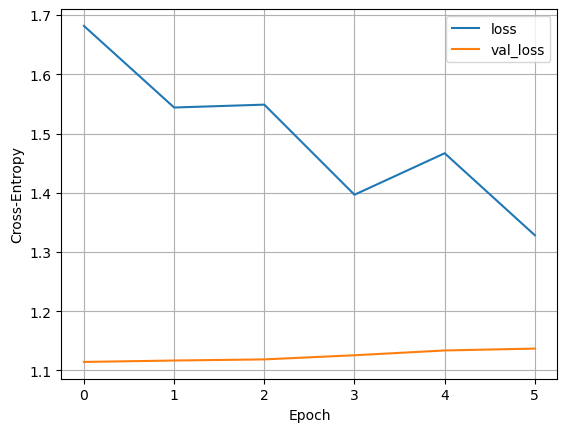

In [85]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True)

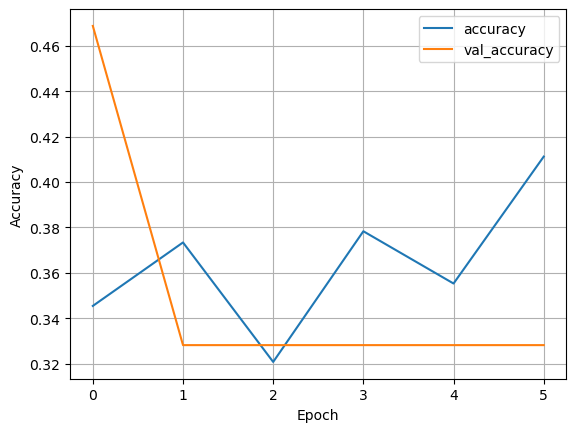

In [86]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [87]:
# Making predictions for the test set
test_probs: np.array = model.predict(val_ds)
# Converting probabilities into specific predictions
test_preds: np.array = np.argmax(test_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [88]:
# Extracting y_test

# Unpack batch labels from val_ds
y_test_batches: list[np.ndarray] = [y for x, y in val_ds]
# Concatonate batches
y_test: np.ndarray = np.concatenate(y_test_batches)

2025-11-17 17:16:06.665352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [89]:
# Examining scores
class_names: list[str] = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

              precision    recall  f1-score   support

           A       0.50      0.62      0.55        21
           B       0.00      0.00      0.00        21
           C       0.45      0.77      0.57        22

    accuracy                           0.47        64
   macro avg       0.32      0.46      0.37        64
weighted avg       0.32      0.47      0.38        64



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


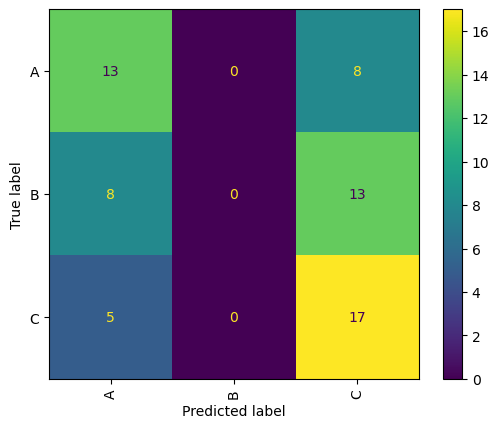

In [90]:
# Displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
);

Let's take a look at some of it's predictions

2025-11-17 17:16:08.596044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


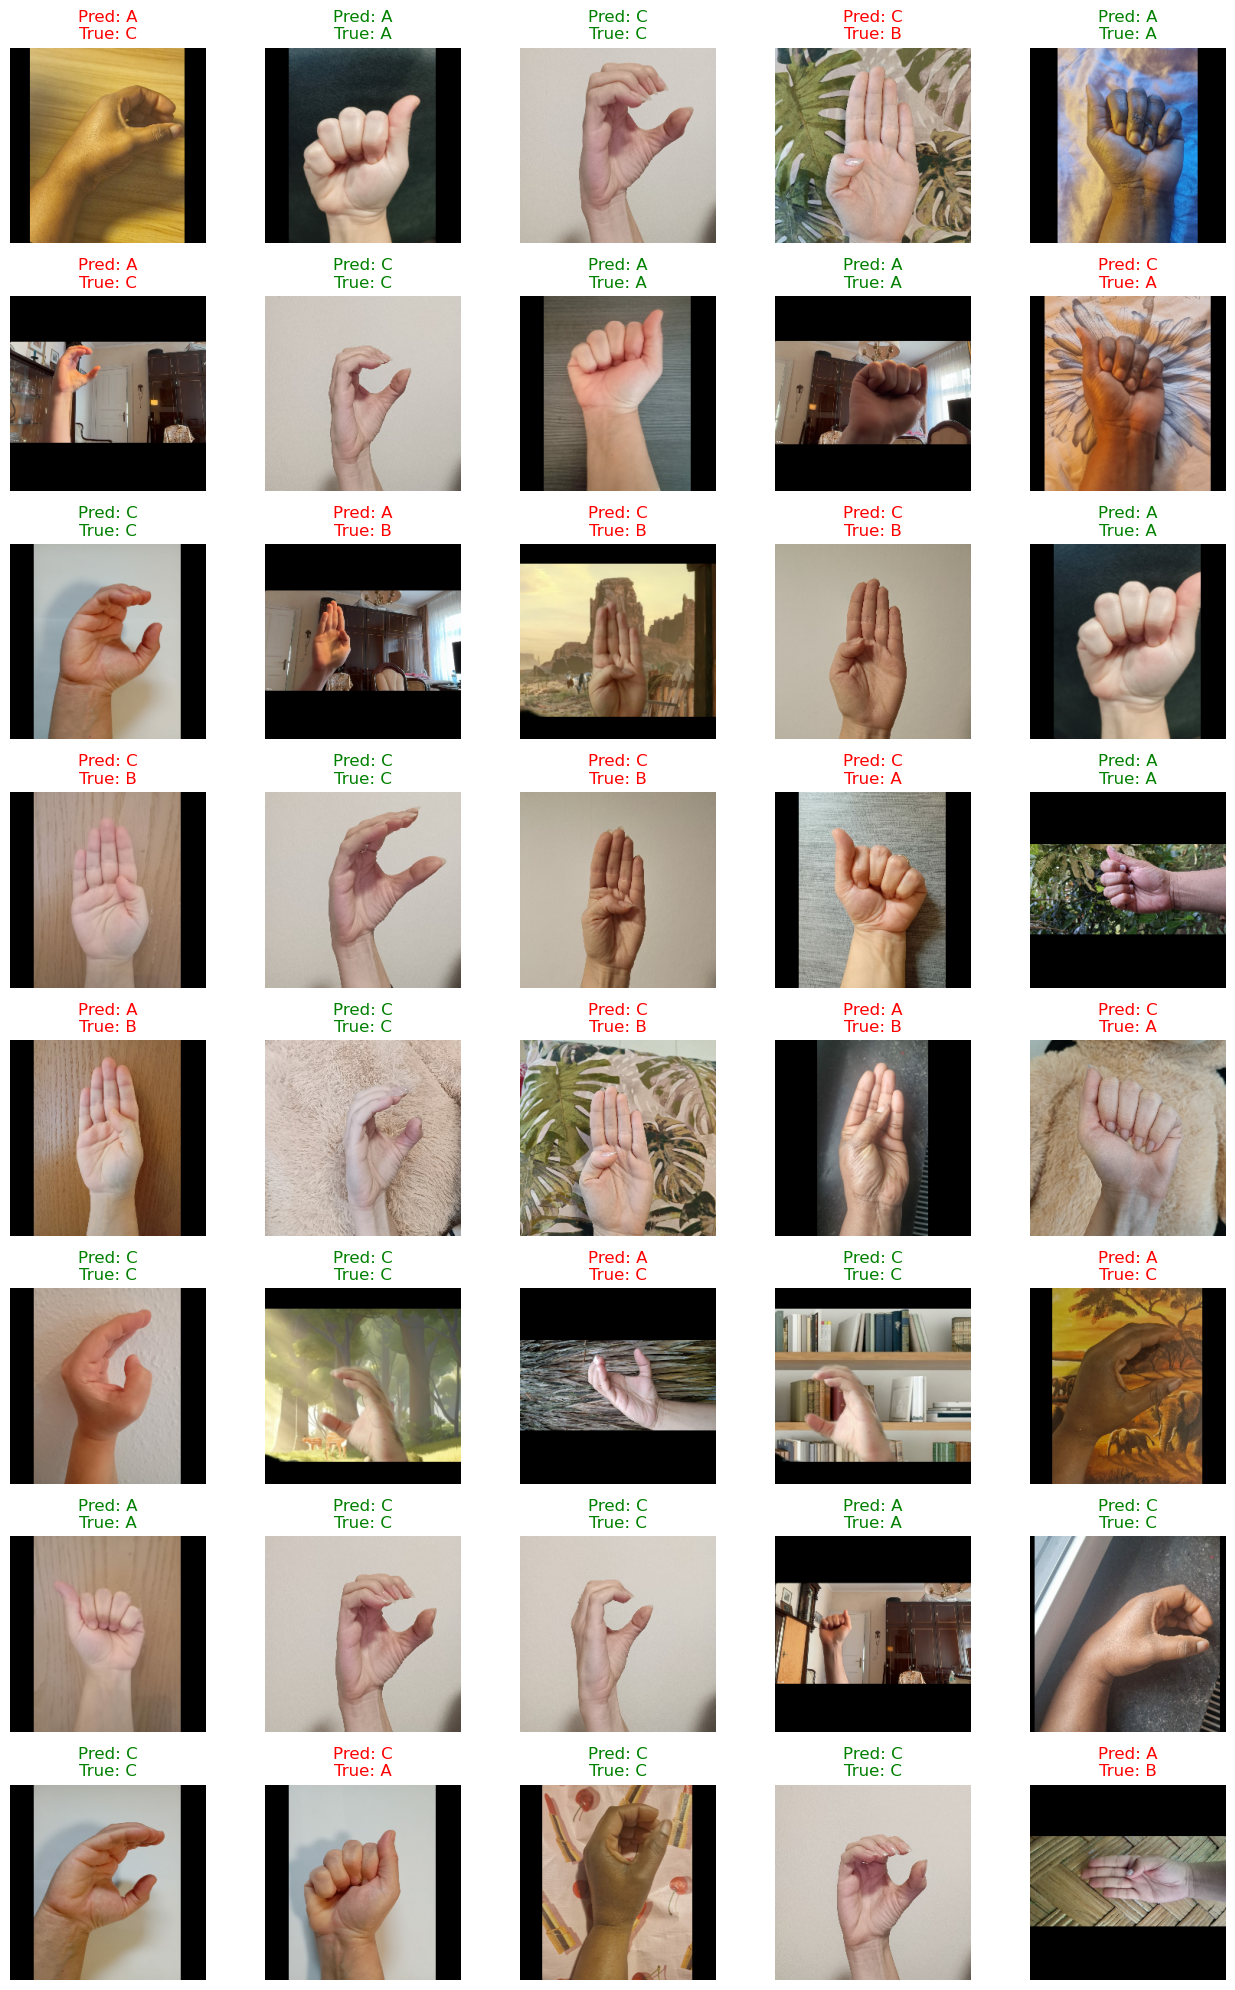

In [91]:
# Visualizing first 40 predictions
num_vis: int = 40

# Extracting images
batched_test_images: list[np.ndarray] = [X_batch for X_batch, y_batch in val_ds]
test_images: np.ndarray = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3),int(num_vis/2)))
columns=5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'), cmap='gray')
    pred: int = test_preds[i]
    true: int = y_test[i]
    colour = 'green' if pred == true else 'red'
    plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', color=colour)
    plt.axis('off')

plt.tight_layout()
plt.show()